# 1: Initial Libraries




In [ ]:
import numpy as np
import pandas as pd
import os, gc, time
import matplotlib.pyplot as plt
from PIL import Image
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from tensorflow.keras.utils import Sequence
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Conv2D, Concatenate, Activation
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 5.0 MB/s 


# 2: Loading Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Steel Defect Detection/severstal-steel-defect-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [ ]:
PATH = "/content/data/"
train = pd.read_csv("/content/data/train.csv")
train.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


In [ ]:
print(len(train))
train_set = train.pivot(index = "ImageId", columns = "ClassId", values = "EncodedPixels")
train_set.reset_index(inplace = True)
train_set = pd.DataFrame({"ImageId" : train_set["ImageId"], "defect_1" : train_set[1], "defect_2" : train_set[2], "defect_3" : train_set[3], "defect_4" : train_set[4]})
train_set.fillna('', inplace = True)
train_set["count"] = np.sum(train_set.iloc[:, 1:] != '', axis = 1).values
print(len(train_set))
train_set.head()


7095
6666


,ImageId,defect_1,defect_2,defect_3,defect_4,count
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1
1,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,,,,1
3,000f6bf48.jpg,,,,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,0014fce06.jpg,,,229501 11 229741 33 229981 55 230221 77 230468...,,1


# 3: Data Processing

In [ ]:
# Data generator
WIDTH = 800
HEIGHT = 128

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, df, batch_size = 16, subset = "train", shuffle = False, preprocess = None, info = {}):
    super().__init__()
    self.df = df
    self.shuffle = shuffle
    self.subset = subset
    self.batch_size = batch_size
    self.preprocess = preprocess
    self.info = info
    self.width = WIDTH
    self.height = HEIGHT

    if self.subset == "train":
      self.data_path = PATH + 'train_images/'
    elif self.subset == "test":
      self.data_path = PATH + 'test_images/'
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.df) / self.batch_size))
  
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.df))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    X = np.empty((self.batch_size, self.height, self.width, 3), dtype = np.float32)
    y = np.empty((self.batch_size, self.height, self.width, 4), dtype = np.int8)
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    for i, item in enumerate (self.df["ImageId"].iloc[indexes]):
      self.info[index * self.batch_size + i] = item
      image = Image.open(self.data_path + item).resize((self.width, self.height))
      X[i,] = img_to_array(image, dtype = np.float32) / 255.0
      if self.subset == "train":
        for j in range(4):
          y[i, :, :, j] = rleToMaskResize(self.df["defect_" + str(j + 1)].iloc[indexes[i]])
    if self.preprocess != None:
      X = self.preProcess(X)
    if self.subset == "train":
      return X, y
    else:
      return X

## 3.1: Convert Encoded Pixel to Mask

In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape = (1600, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [ ]:
def rleToMaskResize(rle):
  # Convert run length encoding to mask
  if (pd.isnull(rle)) | (rle == ''):
    return np.zeros((HEIGHT, WIDTH), dtype = np.uint8)
  height = 256
  width = 1600
  mask = np.zeros(width * height, dtype = np.uint8)
  array = np.asarray([int(x) for x in rle.split()])
  starts = array[0 :: 2] - 1
  lengths = array[1 :: 2]
  for index, start in enumerate(starts):
    mask[int(start) : int(start + lengths[index])] = 1
  return mask.reshape((height, width), order = 'F')[::2, ::2]

In [ ]:
def maskToContour(mask, width = 3):
  # Convert mask to its contour
  w = mask.shape[1]
  h = mask.shape[0]
  mask1 = np.concatenate([mask[:, width:], np.zeros((h, width))], axis = 1)
  mask1 = np.logical_xor(mask, mask1)
  mask2 = np.concatenate([mask[width:, :], np.zeros((width, w))], axis = 0)
  mask2 = np.logical_xor(mask, mask2)
  return np.logical_or(mask1, mask2)

In [ ]:
def maskToPad(mask, pad = 2):
  # Enlarge Mask to include more space around the defect
  w = mask.shape[1]
  h = mask.shape[0]

  # MASK UP
  for k in range(1, pad, 2):
    temp = np.concatenate([mask[k:, :], np.zeros((k, w))], axis = 0)
    mask = np.logical_or(mask, temp)
  
  # MASK DOWN
  for k in range(1, pad, 2):
    temp = np.concatenate([np.zeros((k, w)), mask[:-k, :]], axis = 0)
    mask = np.logical_or(mask, temp)

  # MASK LEFT
  for k in range(1, pad, 2):
    temp = np.concatenate([mask[:, k:], np.zeros((h, k))], axis = 1)
    mask = np.logical_or(mask, temp)
    
  # MASK RIGHT
  for k in range(1, pad, 2):
    temp = np.concatenate([np.zeros((h, k)), mask[:,:-k]], axis = 1)
    mask = np.logical_or(mask, temp)
  
  return mask

## 3.2: Statistics

In [ ]:
plt.figure(figsize = (15, 5))
bar = plt.bar([1, 2, 3, 4], 100 * np.mean(train_set.iloc[:, 1 : 5] != "", axis = 0))
plt.title("Percentage of Training Images with Defect", fontsize = 20)
plt.ylabel("Percentage of Images")
plt.xlabel("Defect Type")
plt.xticks([1, 2, 3, 4])
for rect in bar:
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width() / 2.0, height, "%.1f %%" % height, ha = "center", va = "bottom", fontsize = 20)
plt.ylim((0, 100))
plt.show()

In [ ]:
count = [0, 0, 0, 0]
for i in range(1, 5):
  for item in train_set.iloc[:, i]:
    if item != "":
      count[i - 1] += 1
print(count)

[897, 247, 5150, 801]


## 3.3 Making Data Balanced included Augmentation process



In [ ]:
print(train_set.columns)
unique_test_set = pd.DataFrame([], columns =["ImageId", "defect_1", "defect_2", "defect_3", "defect_4", "count"])
print(unique_test_set.columns)
print(len(unique_test_set))

Index(['ImageId', 'defect_1', 'defect_2', 'defect_3', 'defect_4', 'count'], dtype='object')
Index(['ImageId', 'defect_1', 'defect_2', 'defect_3', 'defect_4', 'count'], dtype='object')
0


In [ ]:
separate_count = np.zeros(5, dtype = np.int8)
train_set_1 = train_set
print("train_set.count: {}".format(len(train_set)))
for i in range(len(train_set_1) - 1, -1 , -1):
  item = train_set_1.iloc[i]
  if item["defect_1"] != "" and item["defect_2"] == "" and item["defect_3"] == "" and item["defect_4"] == "" and separate_count[0] < 50:
    separate_count[0] += 1
    unique_test_set = unique_test_set.append(item, ignore_index = True)
    train_set_1 = train_set_1.drop(index = i)
  elif item["defect_1"] == "" and item["defect_2"] != "" and item["defect_3"] == "" and item["defect_4"] == "" and separate_count[1] < 50:
    separate_count[1] += 1
    unique_test_set = unique_test_set.append(item, ignore_index = True)
    train_set_1 = train_set_1.drop(index = i)
  elif item["defect_1"] == "" and item["defect_2"] == "" and item["defect_3"] != "" and item["defect_4"] == "" and separate_count[2] < 50:
    separate_count[2] += 1
    unique_test_set = unique_test_set.append(item, ignore_index = True)
    train_set_1 = train_set_1.drop(index = i)
  elif item["defect_1"] == "" and item["defect_2"] == "" and item["defect_3"] == "" and item["defect_4"] != "" and separate_count[3] < 50:
    separate_count[3] += 1
    unique_test_set = unique_test_set.append(item, ignore_index = True)
    train_set_1 = train_set_1.drop(index = i)
  elif item["count"] > 1 and separate_count[4] < 50:
    separate_count[4] += 1
    unique_test_set = unique_test_set.append(item, ignore_index = True)
    train_set_1 = train_set_1.drop(index = i)
  if separate_count.all() == 50:
    break
print(separate_count)
print("train_set_1.count: {}".format(len(train_set_1)))
print(len(unique_test_set))

train_set.count: 6666
[50 50 50 50 50]
train_set_1.count: 6416
250


In [ ]:
print(len(unique_test_set))
print(len(train_set_1))

250
6416


In [ ]:
unique_test_set.head(200)

In [ ]:
def rotateImage(image, mask, degree):
  segmap = np.zeros(mask.shape, dtype = bool)
  segmap[:] = mask
  segmap = SegmentationMapOnImage(segmap, shape = image.shape)
  seq = iaa.Sequential([iaa.Affine(rotate = degree)])
  image_aug, mask_aug = seq(image = image, segmentation_maps = segmap)
  return image_aug.astype(np.uint8), mask_aug.get_arr_int()

In [ ]:
def flipImage(image, mask, horizontal = True):
  segmap = np.zeros(mask.shape, dtype= bool)
  segmap[:] = mask
  segmap = SegmentationMapOnImage(segmap, shape = image.shape)
  if horizontal == True:
    seq = iaa.flip.Fliplr(1)
  else:
    seq = iaa.flip.Flipud(1)
  image_aug, mask_aug = seq(image = image, segmentation_maps = segmap)
  return image_aug.astype(np.uint8), mask_aug.get_arr_int()

In [ ]:
count = [0, 0, 0, 0]
for i in range(1, 5):
  for item in train_set_1.iloc[:, i]:
    if item != "":
      count[i -1] += 1
print(count)

[829, 187, 5057, 721]


In [ ]:
# Drop defect 3 util 1291 records left
train_set_1.iloc[len(train_set_1) - 1]
dropcount = 0
arr_index = list(train_set_1.iloc[:].index)
for i in range(len(train_set_1) - 1, -1, -1):
  item = train_set_1.iloc[i]
  if item["defect_1"] == "" and item["defect_2"] == "" and item["defect_3"] != "" and item["defect_4"] == "" and dropcount < 3766:
    dropcount += 1
    train_set_1 = train_set_1.drop(index = arr_index[i])
  if dropcount == 3766:
    break
print(dropcount)

3766


In [ ]:
# Augmentation image for defect 2
for i in range(len(train_set_1) - 1, -1, -1):
  item = train_set_1.iloc[i]
  if item["defect_2"] != "":
    image = load_img(PATH + 'train_images/' + item["ImageId"])
    image = img_to_array(image)
    mask = rle2mask(item["defect_2"])
    
    rotated_180_image, rotated_180_mask = rotateImage(image, mask, 180)
    rotated_10_image, rotated_10_mask = rotateImage(image, mask, 10)
    vertical_flip_image, vertical_flip_mask = flipImage(image, mask, False)
    horizontal_flip_image, horizontal_flip_mask = flipImage(image, mask, True)
    minus_10_flip_rotated_image, minus_10_flip_rotated_mask = rotateImage(horizontal_flip_image, horizontal_flip_mask, -10)
    flip_10_rotated_image, flip_10_rotated_mask = rotateImage(vertical_flip_image, vertical_flip_mask, 10)

    Image.fromarray(rotated_180_image).save(PATH + 'train_images/' + "d2_rotated_180_" + item["ImageId"])
    Image.fromarray(rotated_10_image).save(PATH + 'train_images/' + "d2_rotated_10_" + item["ImageId"])
    Image.fromarray(vertical_flip_image).save(PATH + 'train_images/' + "d2_vertical_flip_" + item["ImageId"])
    Image.fromarray(horizontal_flip_image).save(PATH + 'train_images/' + "d2_horizontal_flip_" + item["ImageId"])
    Image.fromarray(minus_10_flip_rotated_image).save(PATH + 'train_images/' + "d2_minus_10_flip_rotated_" + item["ImageId"])
    Image.fromarray(flip_10_rotated_image).save(PATH + 'train_images/' + "d2_flip_10_rotated_" + item["ImageId"])

    train_set_1 = train_set_1.append({"ImageId" : "d2_rotated_180_" + item["ImageId"], "defect_1" : "", "defect_2" : mask2rle(rotated_180_mask), "defect_3" : "", "defect_4" : "", "count" : 1}, ignore_index = True)
    train_set_1 = train_set_1.append({"ImageId" : "d2_rotated_10_" + item["ImageId"], "defect_1" : "", "defect_2" : mask2rle(rotated_10_mask), "defect_3" : "", "defect_4" : "", "count" : 1}, ignore_index = True)
    train_set_1 = train_set_1.append({"ImageId" : "d2_vertical_flip_" + item["ImageId"], "defect_1" : "", "defect_2" : mask2rle(vertical_flip_mask), "defect_3" : "", "defect_4" : "", "count" : 1}, ignore_index = True)
    train_set_1 = train_set_1.append({"ImageId" : "d2_horizontal_flip_" + item["ImageId"], "defect_1" : "", "defect_2" : mask2rle(horizontal_flip_mask), "defect_3" : "", "defect_4" : "", "count" : 1}, ignore_index = True)
    train_set_1 = train_set_1.append({"ImageId" : "d2_minus_10_flip_rotated_" + item["ImageId"], "defect_1" : "", "defect_2" : mask2rle(minus_10_flip_rotated_mask), "defect_3" : "", "defect_4" : "", "count" : 1}, ignore_index = True)
    train_set_1 = train_set_1.append({"ImageId" : "d2_flip_10_rotated_" + item["ImageId"], "defect_1" : "", "defect_2" : mask2rle(flip_10_rotated_mask), "defect_3" : "", "defect_4" : "", "count" : 1}, ignore_index = True)

In [ ]:
# Augmentation image for defect 1
count_d1 = 0
for i in range((len(train_set_1) - 1), -1, -1):
  item = train_set_1.iloc[i]
  if item["defect_1"] != "" and item["defect_2"] == "" and item["defect_3"] == "" and item["defect_4"] == "" and count_d1 < 462:
    image = load_img(PATH + 'train_images/' + item["ImageId"])
    image = img_to_array(image)
    mask = rle2mask(item["defect_1"])
    rotated_180_image, rotated_180_mask = rotateImage(image, mask, 180)
    Image.fromarray(rotated_180_image).save(PATH + 'train_images/' + "d1_rotated_180_" + item["ImageId"])
    train_set_1 = train_set_1.append({"ImageId" : "d1_rotated_180_" + item["ImageId"], "defect_1" : mask2rle(rotated_180_mask), "defect_2" : "", "defect_3" : "", "defect_4" : "", "count" : 1}, ignore_index = True)
    count_d1 += 1
  if count_d1 == 462:
    break

In [ ]:
# Augmentation image for defect 4
count_d4 = 0
for i in range(len(train_set_1) - 1, -1, -1):
  item = train_set_1.iloc[i]
  if item["defect_4"] != "" and count_d4 < 570:
    image = load_img(PATH + 'train_images/' + item["ImageId"])
    image = img_to_array(image)
    mask = rle2mask(item["defect_4"])
    rotated_180_image, rotated_180_mask = rotateImage(image, mask, 180)
    Image.fromarray(rotated_180_image).save(PATH + 'train_images/' + "d4_rotated_180_" + item["ImageId"])
    train_set_1 = train_set_1.append({"ImageId" : "d4_rotated_180_" + item["ImageId"], "defect_1" : "", "defect_2" : "", "defect_3" : "", "defect_4" : mask2rle(rotated_180_mask), "count" : 1}, ignore_index = True)
    count_d4 += 1
  if count_d4 == 570:
    break

In [ ]:
count = [0, 0, 0, 0]
for i in range(1, 5):
  for item in train_set_1.iloc[:, i]:
    if item != "":
      count[i -1] += 1
print(count)

[1291, 1291, 1291, 1291]


In [ ]:
plt.figure(figsize = (15, 5))
bar = plt.bar([1, 2, 3, 4], 100 * np.mean(train_set_1.iloc[:, 1 : 5] != "", axis = 0))
plt.title("Percentage of Training Images with Defect", fontsize = 20)
plt.ylabel("Percentage of Images")
plt.xlabel("Defect Type")
plt.xticks([1, 2, 3, 4])
for rect in bar:
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width() / 2.0, height, "%.1f %%" % height, ha = "center", va = "bottom", fontsize = 20)
plt.ylim((0, 100))
plt.show()

## 3.4 Plot some sample in data set

In [ ]:
# Defective Image Samples
filenames = {}
defects = list(train_set[train_set["defect_1"] != ""].sample(8).index)
defects += list(train_set[train_set["defect_2"] != ""].sample(8).index)
defects += list(train_set[train_set["defect_3"] != ""].sample(8).index)
defects += list(train_set[train_set["defect_4"] != ""].sample(8).index)

In [ ]:
# Data Generator
train_batches = DataGenerator(train_set[train_set.index.isin(defects)], shuffle = True, info = filenames, batch_size = 16)

In [ ]:
batch_size = 16
# Display Images With Defects
for i, item in enumerate(train_batches):
  plt.figure(figsize = (30, 60))
  for j in range(batch_size):
    plt.subplot(batch_size, 1, j + 1)
    img = item[0][j, ]
    # img = Image.fromarray(img.astype('uint8'))
    # img = np.array(img)
    extra = ' has defect'
    for k in range(4):
      mask = item[1][j, :, :, k]
      mask = maskToPad(mask, pad = 3)
      mask = maskToContour(mask, width = 2)
      if np.sum(mask) != 0:
        extra += ' ' + str(k + 1)
      if k == 0:
        img[mask == 1, 0] = 255
      elif k == 1:
        img[mask == 1, 0] = 255
        img[mask == 1, 1] = 255
      elif k == 2:
        img[mask == 1, 2] = 255
      elif k == 3:
        img[mask == 1, 0] = 255
        img[mask == 1, 1] = 255
        img[mask == 1, 2] = 255
    plt.title(filenames[batch_size * i + j] + extra)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
  plt.subplots_adjust(wspace = 0.05)
  plt.show()

# 4: Dice Coefficient

In [ ]:
# Compute Dice Coefficient aka F1 Score
# the value of intersection over union between ground-truth mask and predicted mask
def dice_coefficient(y_true, y_pred, smooth = 1):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  return (2.0 * intersection * smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)


# 5: Model

In [ ]:
import segmentation_models
from segmentation_models import Unet
segmentation_models.set_framework("tf.keras")
print(segmentation_models.framework())

In [ ]:
model = Unet("efficientnetb5", input_shape = (HEIGHT, WIDTH, 3), encoder_weights = 'imagenet', encoder_freeze = True, classes = 4, activation = "sigmoid")
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = [dice_coefficient])

In [ ]:
model.summary()

In [ ]:
# checkpoint_dice = ModelCheckpoint("Best_Dice_Coefficient.h5", monitor = "val_dice_coefficient", save_best_only = True, mode = 'max', verbose = 1)
# checkpoint_loss = ModelCheckpoint("Best_Loss.h5", monitor = "val_loss", save_best_only = True, mode = 'min', verbose = 1)
earlyStop = EarlyStopping(monitor = "val_loss", patience = 15, mode = "min")

# 6: Create K-Fold for data set and train model

In [ ]:
train_set_1 = train_set_1.sample(frac=1).reset_index(drop = True)
# skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
kFold = KFold(n_splits = 5, shuffle = True)
data_list = []
fold_id = 1
accuracy_arr = []
loss_arr = []
histories = []
train_batches_arr = []
valid_batches_arr = []
train_data_arr = []
valid_data_arr = []
train_index_arr = []
valid_index_arr = []
for train_indexes, valid_indexes in kFold.split(train_set_1.iloc[:]["ImageId"]):
  train_data = train_set_1.iloc[train_indexes]
  valid_data = train_set_1.iloc[valid_indexes]
  train_batches = DataGenerator(train_data, shuffle = True)
  valid_batches = DataGenerator(valid_data)
  train_batches_arr.append(train_batches)
  valid_batches_arr.append(valid_batches)
  train_index_arr.append(train_indexes)
  valid_index_arr.append(valid_indexes)
  train_data_arr.append(train_data)
  valid_data_arr.append(valid_data)
  print("====================Start training Fold: {}====================".format(fold_id))
  history = model.fit(train_batches, validation_data = valid_batches, epochs = 150, callbacks = [earlyStop], verbose = 1)
  print("====================Finish training Fold: {}====================".format(fold_id))
  # scores = model.evaluate(valid_batches)
  # print("Model Evaluation Scores: {}".format(scores))
  histories.append(history)
  # loss_arr.append(scores[0])
  # accuracy_arr.append(scores[1])
  fold_id += 1

# 7: Plot result of histories

In [ ]:
for history in histories:
  plt.figure(figsize = (15, 8))
  plt.plot(range(history.epoch[-1] + 1), history.history['val_dice_coefficient'], label = "val_dice_coefficient")
  plt.plot(range(history.epoch[-1] + 1), history.history['dice_coefficient'], label = "dice_coefficient")
  plt.title("Training Accuracy")

  plt.xlabel("Epoch")
  plt.ylabel("Dice Coefficient")
  plt.legend()
  plt.show()

In [ ]:
for history in histories:
  plt.figure(figsize = (15, 8))
  plt.plot(range(history.epoch[-1] + 1), history.history['val_loss'], label = "val_loss")
  plt.plot(range(history.epoch[-1] + 1), history.history['loss'], label = "loss")
  plt.title("Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

# 8: Evaluate Train and Valid set after training

In [ ]:
train_acc_arr = []
valid_acc_arr = []
train_loss_arr = []
valid_loss_arr = []
accuracy_dict = {}
loss_dict = {}
for i in range(len(train_batches_arr)):
  train_evaluate = model.evaluate(train_batches_arr[i])
  valid_evaluate = model.evaluate(valid_batches_arr[i])

  train_loss_arr.append(train_evaluate[0])
  valid_loss_arr.append(valid_evaluate[0])
  train_acc_arr.append(train_evaluate[1])
  valid_acc_arr.append(valid_evaluate[1])

  print("train_evaluate: {}".format(train_evaluate))
  print("valid_evaluate: {}".format(valid_evaluate))

accuracy_dict = {"train" : train_acc_arr, "valid" : valid_acc_arr}
loss_dict = {"train" : train_loss_arr, "valid" : valid_loss_arr}

60/60 [==============================] - 13s 208ms/step - loss: 0.0016 - dice_coefficient: 0.9472
train_evaluate: [0.0019217651570215821, 0.9408697485923767]
valid_evaluate: [0.001606565318070352, 0.9471715688705444]
60/60 [==============================] - 13s 211ms/step - loss: 0.0017 - dice_coefficient: 0.9479
train_evaluate: [0.0019068258116021752, 0.9406245946884155]
valid_evaluate: [0.001666693715378642, 0.9478727579116821]
60/60 [==============================] - 13s 209ms/step - loss: 0.0016 - dice_coefficient: 0.9417
train_evaluate: [0.0019260894041508436, 0.9431329965591431]
valid_evaluate: [0.0015841855201870203, 0.9416585564613342]
60/60 [==============================] - 13s 209ms/step - loss: 0.0017 - dice_coefficient: 0.9477
train_evaluate: [0.0018972366815432906, 0.94133460521698]
valid_evaluate: [0.0016992882592603564, 0.9476527571678162]
60/60 [==============================] - 13s 210ms/step - loss: 0.0027 - dice_coefficient: 0.9296
train_evaluate: [0.001641007256694

In [ ]:
print(loss_dict)
print(accuracy_dict)

{'train': [0.0019217651570215821, 0.0019068258116021752, 0.0019260894041508436, 0.0018972366815432906, 0.001641007256694138], 'valid': [0.001606565318070352, 0.001666693715378642, 0.0015841855201870203, 0.0016992882592603564, 0.0027336275670677423]}
{'train': [0.9408697485923767, 0.9406245946884155, 0.9431329965591431, 0.94133460521698, 0.9454980492591858], 'valid': [0.9471715688705444, 0.9478727579116821, 0.9416585564613342, 0.9476527571678162, 0.9296228885650635]}


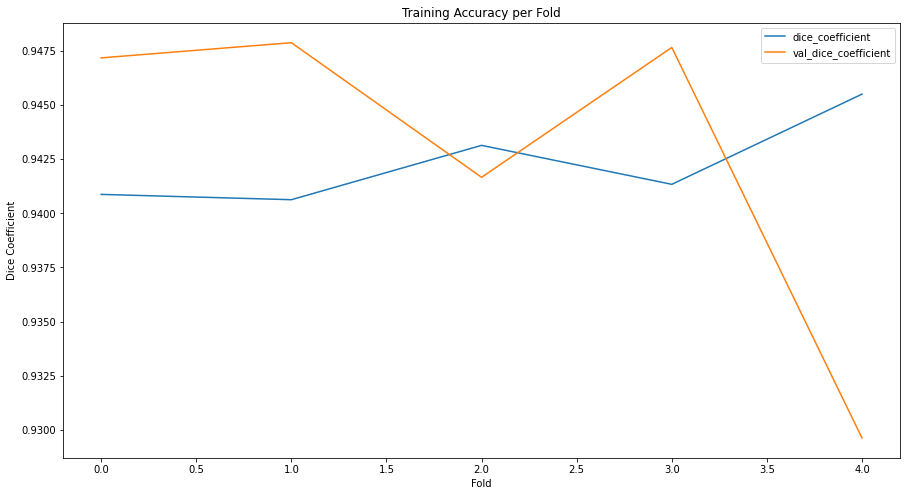

In [ ]:
plt.figure(figsize = (15, 8))
plt.plot(range(5), accuracy_dict["train"], label = "dice_coefficient")
plt.plot(range(5), accuracy_dict["valid"], label = "val_dice_coefficient")
plt.title("Training Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.show()

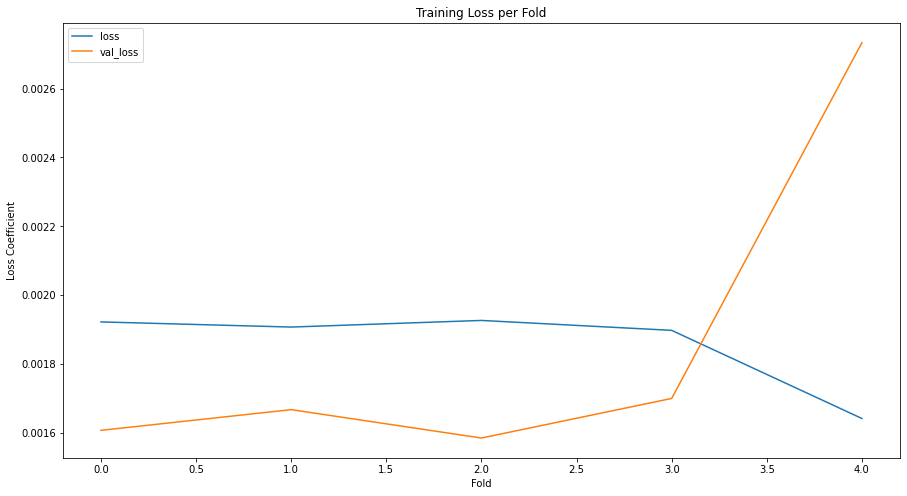

In [ ]:
plt.figure(figsize = (15, 8))
plt.plot(range(5), loss_dict["train"], label = "loss")
plt.plot(range(5), loss_dict["valid"], label = "val_loss")
plt.title("Training Loss per Fold")
plt.xlabel("Fold")
plt.ylabel("Loss Coefficient")
plt.legend()
plt.show()

# 9: Predict in valid set and plot result

In [ ]:
preds = model.predict(valid_batches_arr[0], verbose = 1)

60/60 [==============================] - 14s 196ms/step


In [ ]:
# Predictions Valid Data at 1st Fold
batch_size = 16
for i, batch in enumerate(valid_batches_arr[0]):
  plt.figure(figsize = (20, 36))
  for j in range(batch_size):
    plt.subplot(batch_size, 2, 2 * j + 1)
    image = batch[0][j,]
    img_copy = image.copy()
    defect = 0
    str_defect = " has defect "
    defect_arr = []
    for k in range(4):
      mask = batch[1][j, : , :, k]
      if np.sum(mask) != 0:
        defect = k + 1
        str_defect += " " + str(k + 1)
        defect_arr.append(k)
      mask = maskToPad(mask, pad = 2)
      mask = maskToContour(mask, width = 3)
      if k == 0:
        image[mask == 1, 0] = 255
      elif k == 1:
        image[mask == 1, 0] = 255
        image[mask == 1, 1] = 255
      elif k == 2:
        image[mask == 1, 2] = 255
      elif k == 3:
        image[mask == 1, 0] = 255
        image[mask == 1, 1] = 255
        image[mask == 1, 2] = 255
    if str_defect == " has defect ":
      str_defect = ""
    plt.title("Valid " + valid_data_arr[0].iloc[batch_size * i + j, 0] + str_defect)
    plt.axis("off")
    plt.imshow(image)
    
    defect_values = ""
    plt.subplot(batch_size, 2, 2 * j + 2)
    sum = np.sum(preds[j], axis = (0, 1))
    for item in range(4):
      mask = preds[batch_size * i + j, :, :, item]
      mask[mask < 0.5] = 0
      mask[mask >= 0.5] = 1
      if item == 0:
        img_copy[mask == 1, 0] = 255
      elif item == 1:
        img_copy[mask == 1, 0] = 255
        img_copy[mask == 1, 1] = 255
      elif item == 2:
        img_copy[mask == 1, 2] = 255
      elif item == 3:
        img_copy[mask == 1, 0] = 255
        img_copy[mask == 1, 1] = 255
        img_copy[mask == 1, 2] = 255
      if np.sum(mask) >= 200:
        defect_values += " " + str(item + 1)
      plt.imshow(img_copy)
    plt.axis("off")
    # max_pixel = np.round(np.max(mask), 3)
    # plt.title("Defect Prediction " + str(defect_values) + " (max pixel = " + str(max_pixel) + ")")
    plt.title("Defect Prediction " + str(defect_values))
  plt.subplots_adjust(wspace=0.05)
  plt.show()

Mask size with Threshold: 0.1


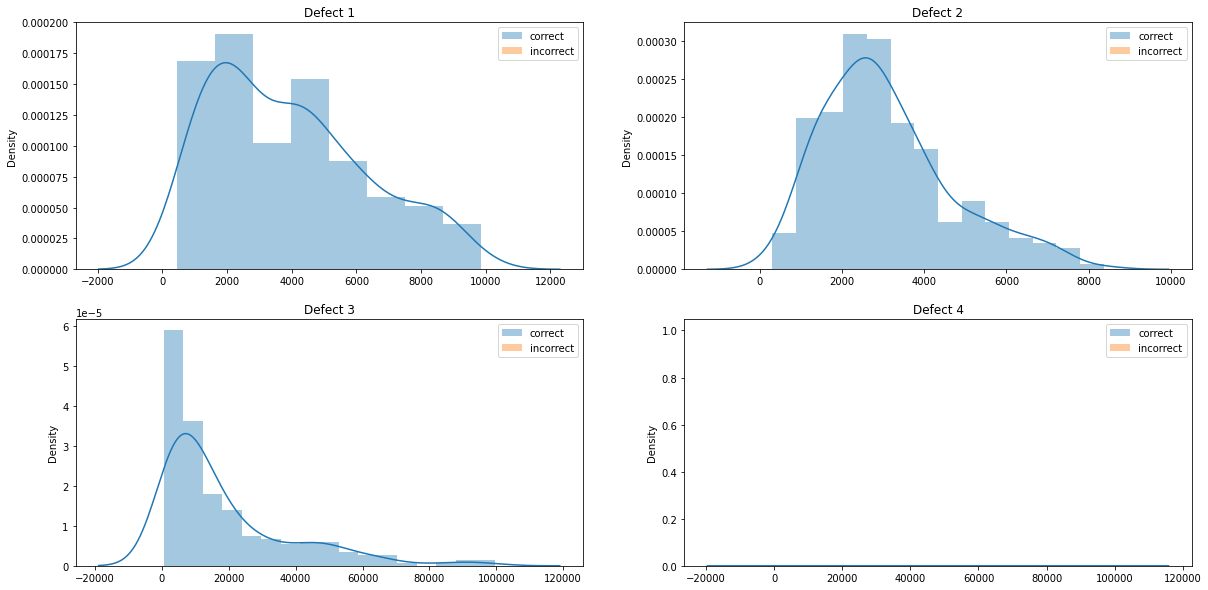

In Threshold: 0.1	Defect 1 has 259 correct and 0 incorrect masks
In Threshold: 0.1	Defect 2 has 255 correct and 0 incorrect masks
In Threshold: 0.1	Defect 3 has 265 correct and 0 incorrect masks
In Threshold: 0.1	Defect 4 has 251 correct and 1 incorrect masks

Mask size with Threshold: 0.2


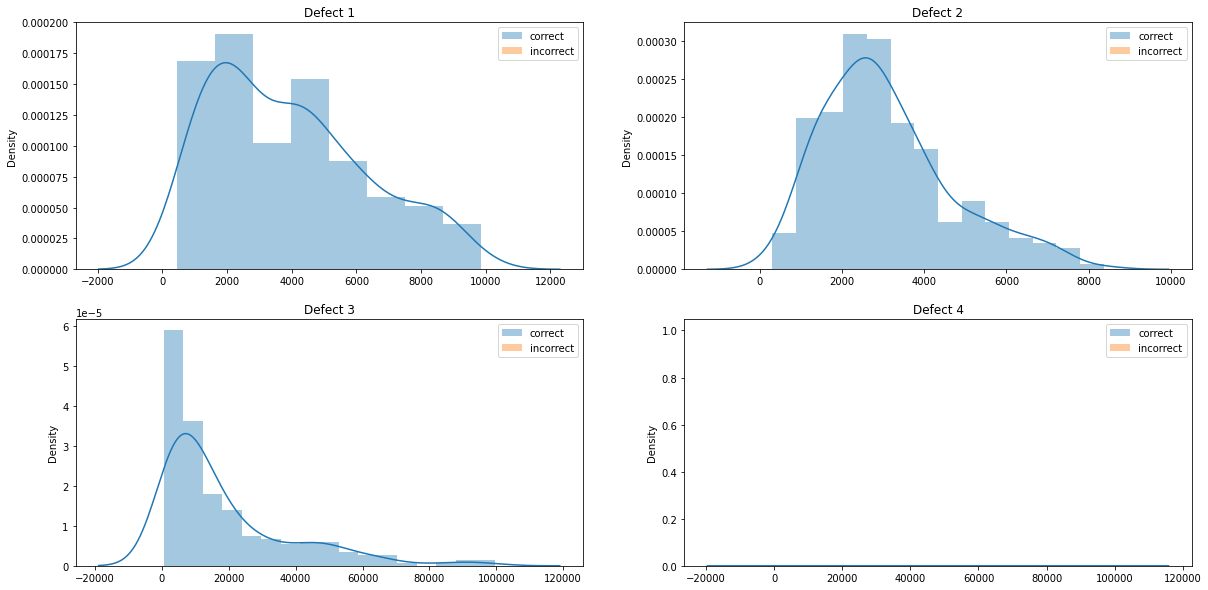

In Threshold: 0.2	Defect 1 has 259 correct and 0 incorrect masks
In Threshold: 0.2	Defect 2 has 255 correct and 0 incorrect masks
In Threshold: 0.2	Defect 3 has 265 correct and 0 incorrect masks
In Threshold: 0.2	Defect 4 has 251 correct and 1 incorrect masks

Mask size with Threshold: 0.5


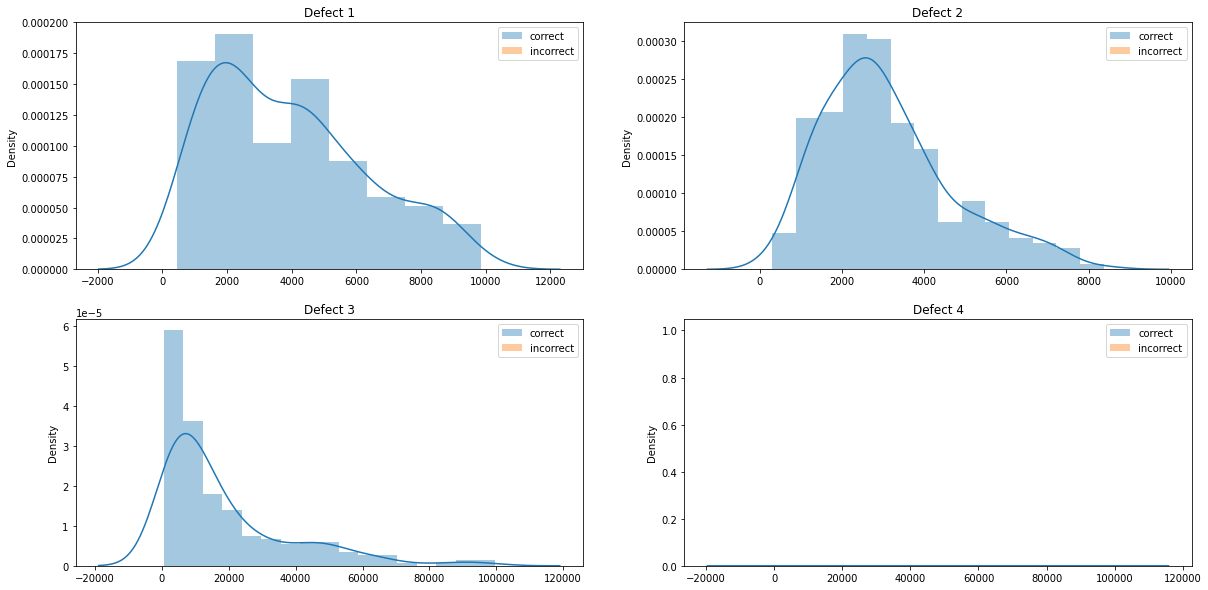

In Threshold: 0.5	Defect 1 has 259 correct and 0 incorrect masks
In Threshold: 0.5	Defect 2 has 255 correct and 0 incorrect masks
In Threshold: 0.5	Defect 3 has 265 correct and 0 incorrect masks
In Threshold: 0.5	Defect 4 has 251 correct and 1 incorrect masks

Mask size with Threshold: 0.7


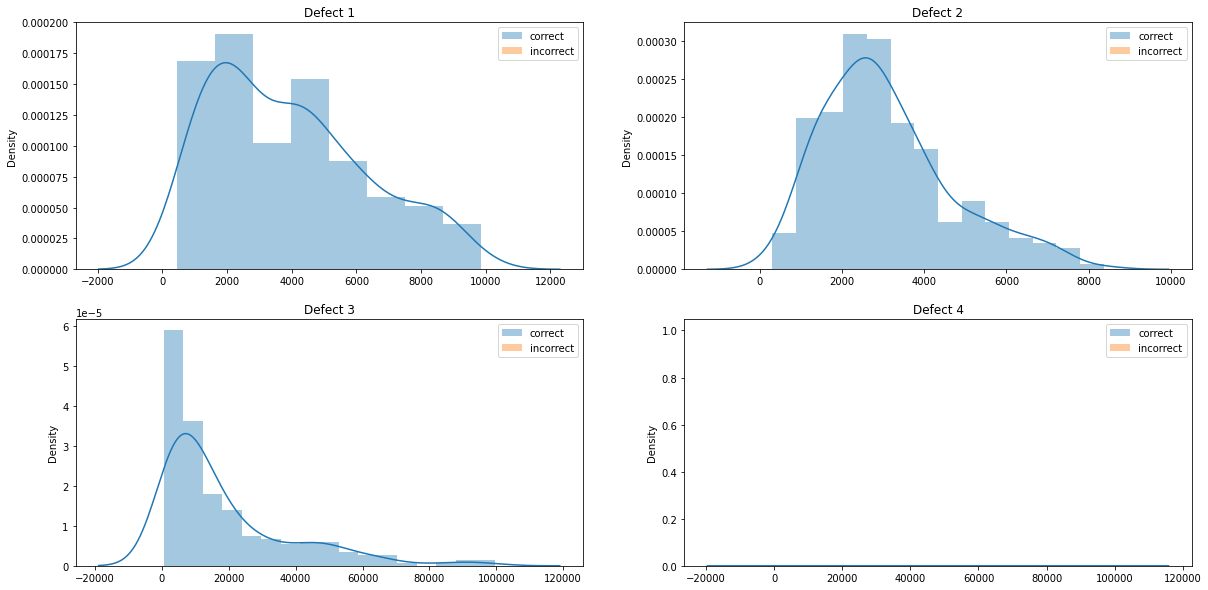

In Threshold: 0.7	Defect 1 has 259 correct and 0 incorrect masks
In Threshold: 0.7	Defect 2 has 255 correct and 0 incorrect masks
In Threshold: 0.7	Defect 3 has 265 correct and 0 incorrect masks
In Threshold: 0.7	Defect 4 has 251 correct and 1 incorrect masks

Mask size with Threshold: 0.9


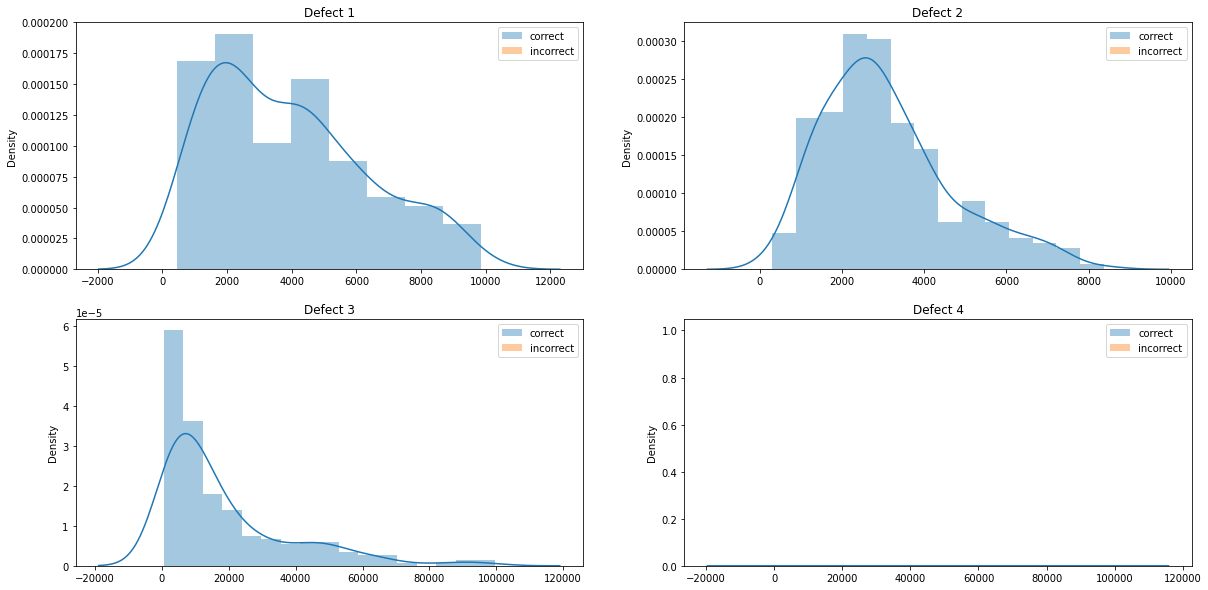

In Threshold: 0.9	Defect 1 has 259 correct and 0 incorrect masks
In Threshold: 0.9	Defect 2 has 255 correct and 0 incorrect masks
In Threshold: 0.9	Defect 3 has 265 correct and 0 incorrect masks
In Threshold: 0.9	Defect 4 has 251 correct and 1 incorrect masks



In [ ]:
# Plot Results for Validation set data
import seaborn as sns
pix_min = 250
# for z, preds in enumerate(preds_arr):
# print("Data in Fold: {}".format(z + 1))
# valid_indexes = valid_index_arr[z]
for THRESHOLD in [0.1, 0.2, 0.5, 0.7, 0.9]:
  print("==============================")
  print("Mask size with Threshold: {}".format(THRESHOLD))
  print("==============================")

  correct = [[], [], [], []]
  incorrect = [[], [], [], []]
  for i in range(len(preds)):
    preds_copy = preds[i].copy()
    preds_copy[preds_copy >= THRESHOLD] = 1
    preds_copy[preds_copy < THRESHOLD] = 0
    sum = np.sum(preds_copy, axis = (0, 1))
    for j in range(4):
      if (4 * sum[j]) < pix_min:
        continue
      if valid_data_arr[0].iloc[i, j + 1] == "":
        incorrect[j].append(4 * sum[j])
      else:
        correct[j].append(4 * sum[j])
    
  plt.figure(figsize = (20, 10))
  for k in range(4):
    limit = [10000, 10000, 100000, 100000][k]
    plt.subplot(2, 2, k + 1)
    sns.distplot([x for x in correct[k] if x < limit], label = "correct")
    sns.distplot([x for x in incorrect[k] if x < limit], label = "incorrect")
    plt.title("Defect " + str(k + 1))
    plt.legend()
  plt.show()
  for h in range(4):
    a1 = np.array(correct[h])
    a2 = np.array(incorrect[h])
    print("In Threshold: {}\tDefect {} has {} correct and {} incorrect masks".format(THRESHOLD, (h + 1), len(a1[a1 != 0]), len(a2[a2 != 0])))
  print()
  # print("============================================================")

# 10: Save and load Model

In [ ]:
# Saving Model
model.save("Unet_Steel_Defect_Detection_28_09_2021.h5")

In [ ]:
#Load model
model = load_model("/content/drive/MyDrive/Unet_Steel_Defect_Detection_28_09_2021.h5", custom_objects = {"dice_coefficient" : dice_coefficient}, compile = True)

# 11: Predict in Unique Test set and Test ste without ground-truth masks from the competition

In [ ]:
test_batches = DataGenerator(unique_test_set.iloc[:], batch_size = 10)
test_set = pd.read_csv("/content/data/sample_submission.csv")
test_batches_1 = DataGenerator(test_set.iloc[::2], subset = "test", batch_size = 16)

In [ ]:
test_preds = model.predict(test_batches, verbose = 1)
test_preds_1 = model.predict(test_batches_1, verbose = 1)

172/172 [==============================] - 222s 1s/step


## 11.1: Evaluate and plot predicted result of Unique Test set

In [ ]:
print(loss_dict)
print(accuracy_dict)
test_evaluate = model.evaluate(test_batches)
print(test_evaluate)

{'train': [0.0019217651570215821, 0.0019068258116021752, 0.0019260894041508436, 0.0018972366815432906, 0.001641007256694138], 'valid': [0.001606565318070352, 0.001666693715378642, 0.0015841855201870203, 0.0016992882592603564, 0.0027336275670677423]}
{'train': [0.9408697485923767, 0.9406245946884155, 0.9431329965591431, 0.94133460521698, 0.9454980492591858], 'valid': [0.9471715688705444, 0.9478727579116821, 0.9416585564613342, 0.9476527571678162, 0.9296228885650635]}
25/25 [==============================] - 4s 154ms/step - loss: 0.0453 - dice_coefficient: 0.7118
[0.04534276947379112, 0.7118356227874756]


In [ ]:
# Predictions in Unique Test Set from Trainning set (200 records)
y_true = np.zeros((len(unique_test_set), 4), dtype = np.int8)
y_pred = np.zeros((len(unique_test_set), 4), dtype = np.int8)
batch_size = 10
for i, batch in enumerate(test_batches):
  plt.figure(figsize = (20, 36))
  for j in range(batch_size):
    plt.subplot(batch_size, 2, 2 * j + 1)
    image = batch[0][j,]
    img_copy = image.copy()
    defect = 0
    str_defect = " has defect "
    defect_arr = []
    for k in range(4):
      mask = batch[1][j, : , :, k]
      if np.sum(mask) != 0:
        y_true[(batch_size * i + j), k] = 1
        defect = k + 1
        str_defect += " " + str(k + 1)
        defect_arr.append(k)
      mask = maskToPad(mask, pad = 2)
      mask = maskToContour(mask, width = 3)
      if k == 0:
        image[mask == 1, 0] = 255
      elif k == 1:
        image[mask == 1, 0] = 255
        image[mask == 1, 1] = 255
      elif k == 2:
        image[mask == 1, 2] = 255
      elif k == 3:
        image[mask == 1, 0] = 255
        image[mask == 1, 1] = 255
        image[mask == 1, 2] = 255
    if str_defect == " has defect ":
      str_defect = ""
    plt.title("Test " + unique_test_set.iloc[batch_size * i + j, 0] + str_defect)
    plt.axis("off")
    plt.imshow(image)
    
    defect_values = ""
    plt.subplot(batch_size, 2, 2 * j + 2)
    sum = np.sum(test_preds[j], axis = (0, 1))
    for item in range(4):
      mask = test_preds[batch_size * i + j, :, :, item]
      # mask[mask < 0.5] = 0
      # mask[mask >= 0.5] = 1
      if item == 0:
        img_copy[mask >= 0.5, 0] = 255
      elif item == 1:
        img_copy[mask >= 0.5, 0] = 255
        img_copy[mask >= 0.5, 1] = 255
      elif item == 2:
        img_copy[mask >= 0.5, 2] = 255
      elif item == 3:
        img_copy[mask >= 0.5, 0] = 255
        img_copy[mask >= 0.5, 1] = 255
        img_copy[mask >= 0.5, 2] = 255
      if np.sum(mask) >= 200:
        y_pred[(batch_size * i + j), item] = 1
        defect_values += " " + str(item + 1)
      plt.imshow(img_copy)
    plt.axis("off")
    # max_pixel = np.round(np.max(mask), 3)
    # plt.title("Defect Prediction " + str(defect_values) + " (max pixel = " + str(max_pixel) + ")")
    plt.title("Defect Prediction " + str(defect_values))
  plt.subplots_adjust(wspace=0.05)
  plt.show()

Mask size with Threshold: 0.1


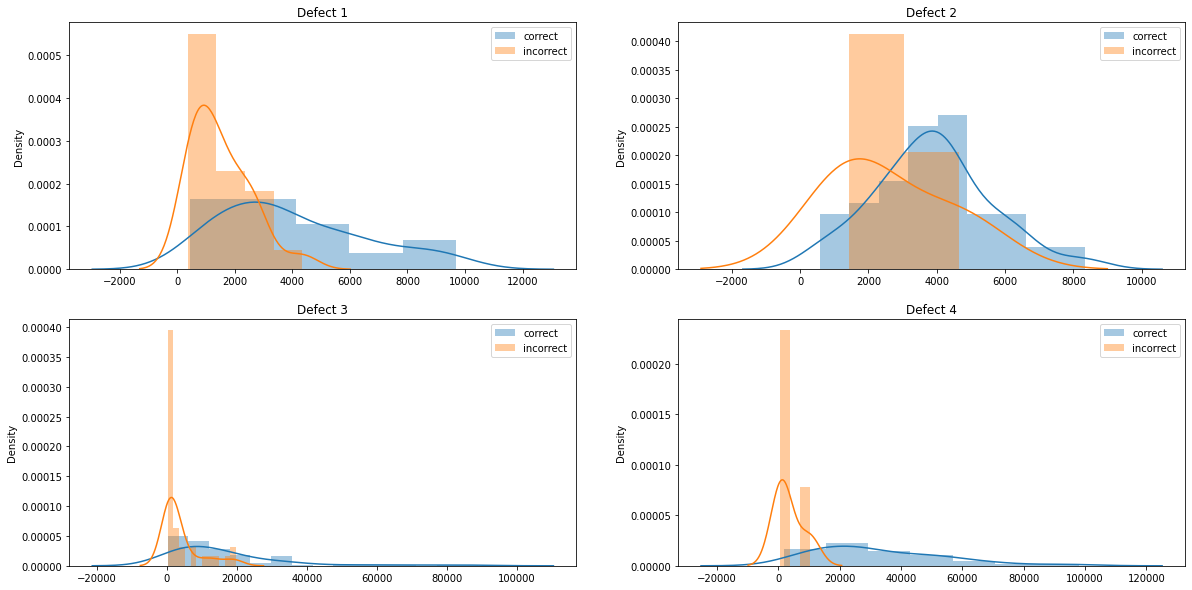

In Threshold: 0.1	Defect 1 has 60 correct and 22 incorrect masks
In Threshold: 0.1	Defect 2 has 60 correct and 3 incorrect masks
In Threshold: 0.1	Defect 3 has 88 correct and 39 incorrect masks
In Threshold: 0.1	Defect 4 has 80 correct and 4 incorrect masks

Mask size with Threshold: 0.2


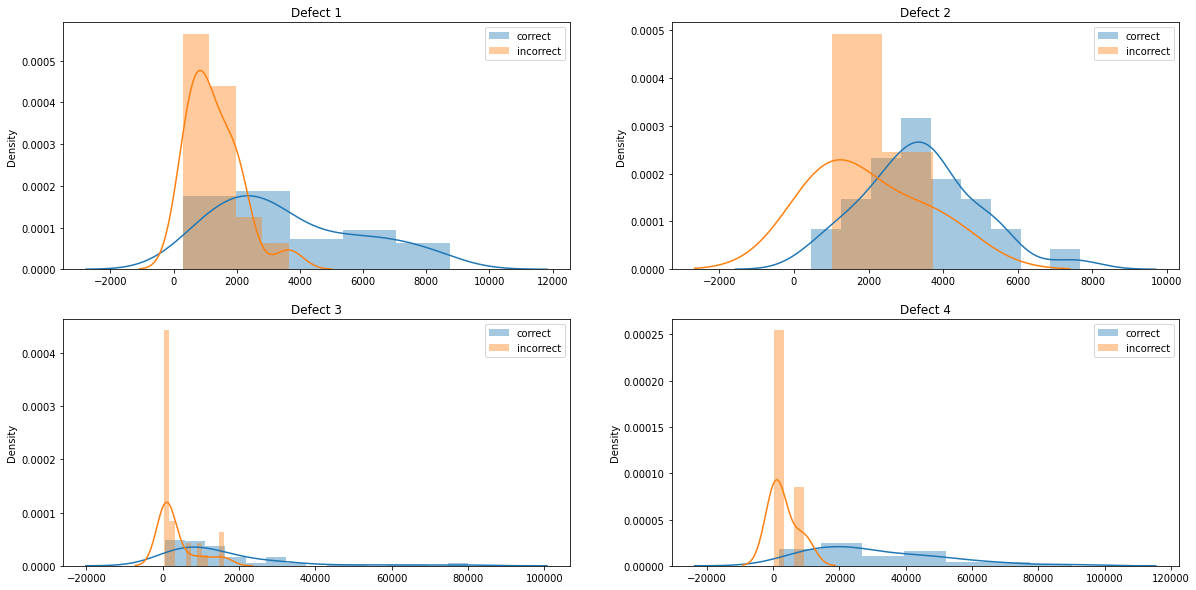

In Threshold: 0.2	Defect 1 has 59 correct and 19 incorrect masks
In Threshold: 0.2	Defect 2 has 59 correct and 3 incorrect masks
In Threshold: 0.2	Defect 3 has 83 correct and 33 incorrect masks
In Threshold: 0.2	Defect 4 has 80 correct and 4 incorrect masks

Mask size with Threshold: 0.5


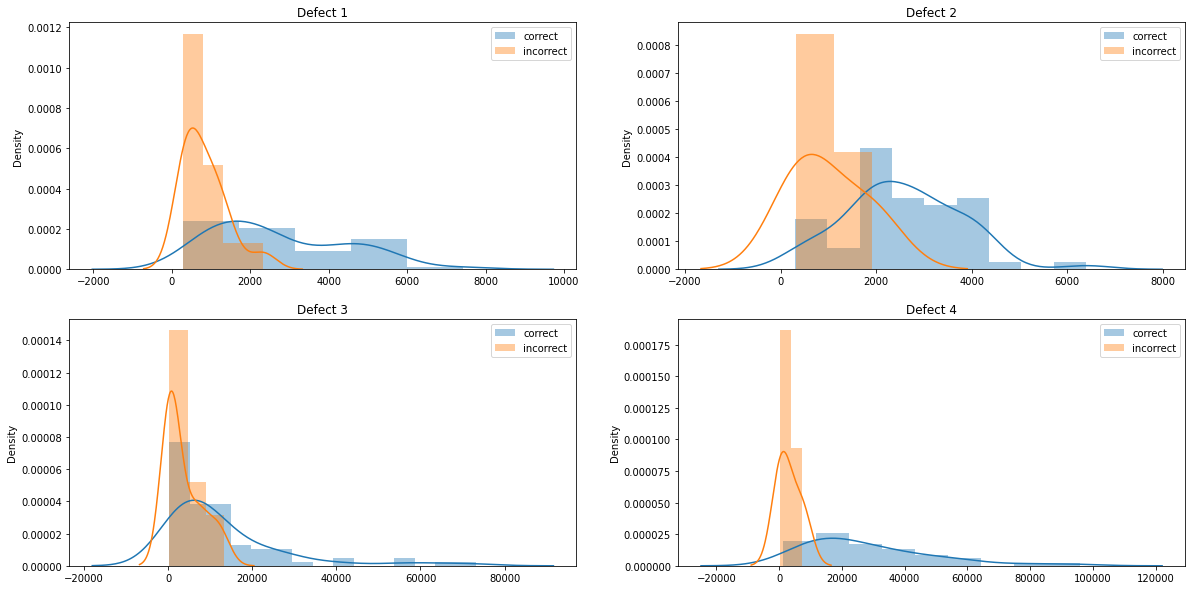

In Threshold: 0.5	Defect 1 has 56 correct and 15 incorrect masks
In Threshold: 0.5	Defect 2 has 58 correct and 3 incorrect masks
In Threshold: 0.5	Defect 3 has 82 correct and 22 incorrect masks
In Threshold: 0.5	Defect 4 has 80 correct and 3 incorrect masks

Mask size with Threshold: 0.7


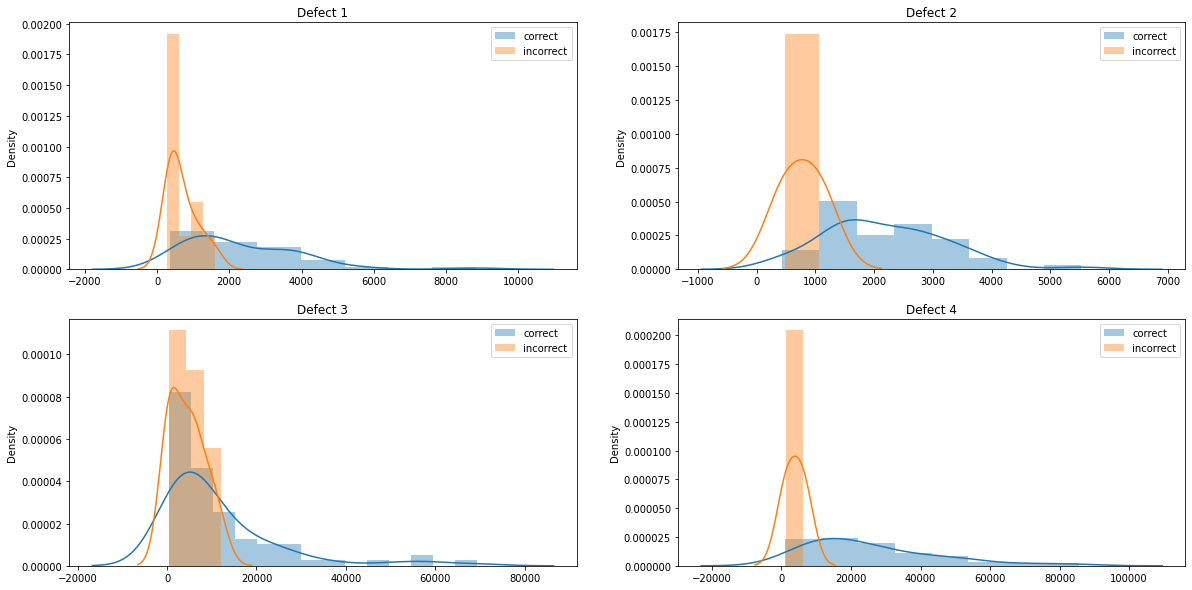

In Threshold: 0.7	Defect 1 has 55 correct and 11 incorrect masks
In Threshold: 0.7	Defect 2 has 56 correct and 2 incorrect masks
In Threshold: 0.7	Defect 3 has 81 correct and 14 incorrect masks
In Threshold: 0.7	Defect 4 has 80 correct and 2 incorrect masks

Mask size with Threshold: 0.9


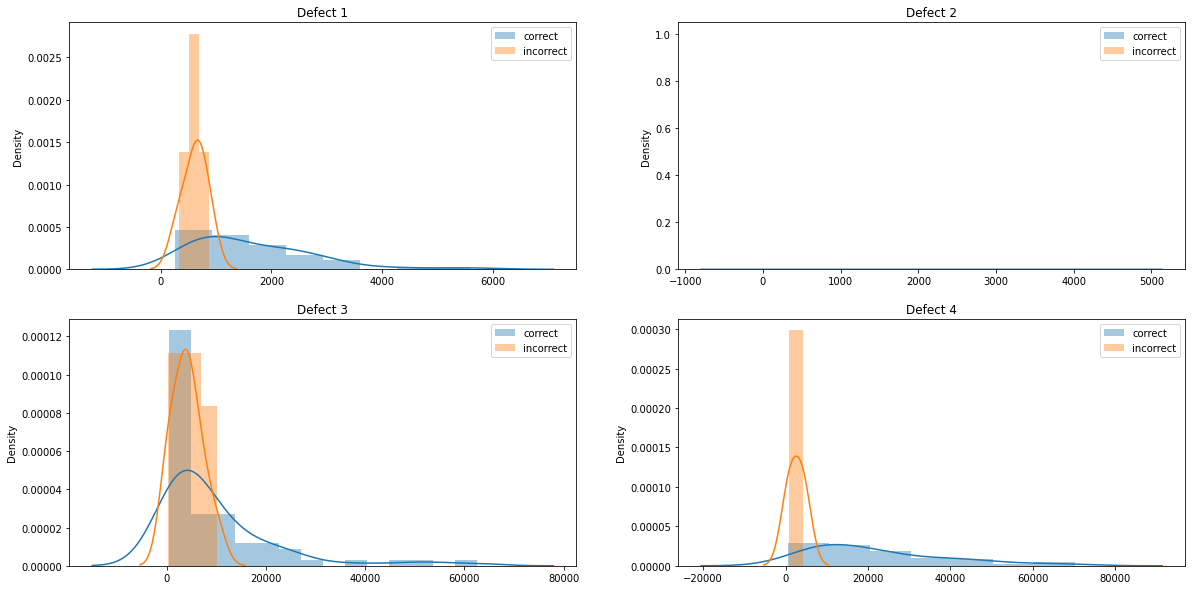

In Threshold: 0.9	Defect 1 has 52 correct and 4 incorrect masks
In Threshold: 0.9	Defect 2 has 53 correct and 1 incorrect masks
In Threshold: 0.9	Defect 3 has 77 correct and 11 incorrect masks
In Threshold: 0.9	Defect 4 has 80 correct and 2 incorrect masks



In [ ]:
# Plot Results for Validation set data
import seaborn as sns
pix_min = 250
# for z, preds in enumerate(preds_arr):
# print("Data in Fold: {}".format(z + 1))
# valid_indexes = valid_index_arr[z]
for THRESHOLD in [0.1, 0.2, 0.5, 0.7, 0.9]:
  print("==============================")
  print("Mask size with Threshold: {}".format(THRESHOLD))
  print("==============================")

  correct = [[], [], [], []]
  incorrect = [[], [], [], []]
  for i in range(len(test_preds)):
    preds_copy = test_preds[i].copy()
    preds_copy[preds_copy >= THRESHOLD] = 1
    preds_copy[preds_copy < THRESHOLD] = 0
    sum = np.sum(preds_copy, axis = (0, 1))
    for j in range(4):
      if (4 * sum[j]) < pix_min:
        continue
      if unique_test_set.iloc[i, j + 1] == "":
        incorrect[j].append(4 * sum[j])
      else:
        correct[j].append(4 * sum[j])
    
  plt.figure(figsize = (20, 10))
  for k in range(4):
    limit = [10000, 10000, 100000, 100000][k]
    plt.subplot(2, 2, k + 1)
    sns.distplot([x for x in correct[k] if x < limit], label = "correct")
    sns.distplot([x for x in incorrect[k] if x < limit], label = "incorrect")
    plt.title("Defect " + str(k + 1))
    plt.legend()
  plt.show()
  for h in range(4):
    a1 = np.array(correct[h])
    a2 = np.array(incorrect[h])
    print("In Threshold: {}\tDefect {} has {} correct and {} incorrect masks".format(THRESHOLD, (h + 1), len(a1[a1 != 0]), len(a2[a2 != 0])))
  print()
  # print("============================================================")

## 11.2: Accuracy score of classify labels between ground-truth masks and predicted masks of Unique Test set




In [ ]:
acc_score = accuracy_score(y_true, y_pred)
acc_score_non_normalize = accuracy_score(y_true, y_pred, normalize = False)
print("Accuracy Score: {}".format(acc_score))
print("Accuracy Score per record: {}".format(acc_score_non_normalize))

Accuracy Score: 0.82
Accuracy Score per record: 205


In [ ]:
accuracy_value = 0
accuracy_no_normalize = 0
for i in range(len(y_true)):
  accuracy_value += accuracy_score(y_true[i], y_pred[i])
  accuracy_no_normalize += accuracy_score(y_true[i], y_pred[i], normalize = False)
mean_accuracy = accuracy_value / len(y_true)
print("Accuracy Value: ", mean_accuracy)
print("Accuracy Score per record: {} / {}".format(accuracy_no_normalize, len(y_true) * 4))

Accuracy Value:  0.949
Accuracy Score per record: 949 / 1000


## 11.3: Confusion Matrix of classify labels between ground-truth masks and predicted masks of Unique Test set

In [ ]:
multi_confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)
print("Confusion Matrix of 4 defect ypes:\n", multi_confusion_matrix)

Confusion Matrix of 4 defect ypes:
 [[[177   5]
  [ 13  55]]

 [[189   1]
  [  7  53]]

 [[144  13]
  [ 10  83]]

 [[169   1]
  [  1  79]]]


## 11.4: Plot result of Test set without ground-truth masks from the competition

In [ ]:
batch_size = 16
# Predictions
for i, batch in enumerate(test_batches_1):
  plt.figure(figsize = (20, 36))
  for j in range(batch_size):
    plt.subplot(batch_size, 2, 2 * j + 1)
    image = batch[j]
    plt.title("Test " + test_set.iloc[batch_size * i + j, 0])
    plt.axis("off")
    plt.imshow(image)

    defect_values = ""
    final_mask = np.zeros((HEIGHT, WIDTH, 3), dtype = np.float32)
    plt.subplot(batch_size, 2, 2 * j + 2)
    for item in range(4):
      mask = test_preds_1[batch_size * i + j, :, :, item]
      if item == 0:
        image[mask >= 0.5, 0] = 255
      elif item == 1:
        image[mask >= 0.5, 0] = 255
        image[mask >= 0.5, 1] = 255
      elif item == 2:
        image[mask >= 0.5, 2] = 255
      elif item == 3:
        image[mask >= 0.5, 0] = 255
        image[mask >= 0.5, 1] = 255
        image[mask >= 0.5, 2] = 255
      if np.sum(mask) >= 200:
        defect_values += " " + str(item + 1)
      plt.imshow(image)
    plt.axis("off")
    # max_pixel = np.round(np.max(mask), 3)
    # plt.title("Defect Prediction " + str(defect_values) + " (max pixel = " + str(max_pixel) + ")")
    plt.title("Defect Prediction " + str(defect_values))
  plt.subplots_adjust(wspace=0.05)
  plt.show()